# **Introduction to TF-IDF**

**[TF-IDF](https://en.wikipedia.org/wiki/Tf–idf)** (Term Frequency-Inverse Document Frequency) is a way of measuring how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics:

*   Term Frequency (TF): how many times a word appears in a document.
*   Inverse Document Frequency (IDF): the inverse document frequency of the word across a collection of documents. Rare words have high scores, common words have low scores.

TF-IDF could be used for information retrieval, text analysis, keyword extraction, and as a way of obtaining numeric features from text for machine learning algorithms.

## Motivation for TF-IDF

TF-IDF was originally developed for document search and information retrieval. Say, you want to build a system that has to find the most relevant documents for a given input query.

Suppose you develop a tool for technical documentation. If you get a query "asynchronous update". The system would give each document a higher score proportionally to the frequencies of the query words found in the document, weighting more rare words like "asynchronous" with respect to common words like "update".

### How do we compute TF-IDF?

There are several ways of calculating TF, with the simplest being a raw count of instances a word appears in a document.

> TF(word, document) = “number of occurrences of the word in the document” / “number of words in the document”

IDF can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm. If the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.

> IDF(word) = log(number of documents / number of documents that contain the word)


Notice that if if a word appears in all of the documents and thus is irrelevant word it does not contribute to the TF-IDF scores.

There are better-performing ranking functions in the information-retrieval literature. You can strat with [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25) and dig as deep as you want.

# Multiclass Text Classification with TF-IDF

We work with a sample from the actual dataset containing consumer complaints. The full dataset could be found [here](https://catalog.data.gov/dataset/consumer-complaint-database).

In [1]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
df=pd.read_csv('train_data.txt', sep=' ::: ', header=None)

C:\Users\User\AppData\Local\Temp\ipykernel_34232\1307538600.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('train_data.txt', sep=' ::: ', header=None)


### Exploration and Preprocessing

In [18]:
df.head() #this way you can display columns as rows.

,0,1,2,3
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [19]:
df = df.drop(columns=[0])
df = df.rename(columns={1: "Title", 2: "Genre", 3: "Description"})
df.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


Let's remove some information that we do not need and build another dataframe that contains "Product" and "Consumer complaint narrative" (renamed as "Complaint").

In [30]:
# Create a new dataframe with two columns
df1 = df[['Genre', 'Title', 'Description']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Description'])]

# Renaming second column for a simpler name
#df1.columns = ['Product', 'Complaint']

df1.shape

(54214, 3)

In [6]:
# Percentage of complaints that had text field
total = df1['Title'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [7]:
pd.DataFrame(df1.Genre.unique()).values

array([['drama'],
       ['thriller'],
       ['adult'],
       ['documentary'],
       ['comedy'],
       ['crime'],
       ['reality-tv'],
       ['horror'],
       ['sport'],
       ['animation'],
       ['action'],
       ['fantasy'],
       ['short'],
       ['sci-fi'],
       ['music'],
       ['adventure'],
       ['talk-show'],
       ['western'],
       ['family'],
       ['mystery'],
       ['history'],
       ['news'],
       ['biography'],
       ['romance'],
       ['game-show'],
       ['musical'],
       ['war']], dtype=object)

There are 17 different classes or categories that we can use as out target variable. However some classes contain smaller ones. For example, "Credit card or prepaid card" contains "Credit card" and "Prepaid card". Let us rename some categories to avoid potential conflicts.

In [22]:
# let's work with a smaller smaple of the data to speed things up
df2 = df1.sample(10000, random_state=1).copy()
df1 = df1.sample(10000, random_state=1).copy()

In [31]:
pd.DataFrame(df1.Genre.unique())
df1.Genre.value_counts()

drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: Genre, dtype: int64

In [8]:
df2 = df1
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df1['Genre'].factorize()[0]
category_id_df = df2[['Genre', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Genre']].values)

# New dataframe
df2.head()

,Genre,Title,Description,category_id
10689,documentary,"Land of Sciacchetra' - Passion, Culture, Legac...",This documentary film is a heartfelt glimpse a...,0
32392,short,The Red Ribbon (2004),"According to an old Chinese fairytale, the god...",1
47445,short,A Little Worm (1995),"In 1929, in Chicago, 12 year old Larry Adler w...",1
11729,adventure,Alone in the Wild: Freddie Flintoff (2011),England Cricket hero Freddie Flintoff spends e...,2
1298,documentary,El Patio (2016),Three gravediggers lovingly maintain the peace...,0


Let us now calculate TF-IDF scores.

In [24]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Description).toarray()
#features = tfidf.fit_transform(df2.Title).toarray()

labels = df2.Genre

print("Each of the %d movie names is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 movie names is represented by 15667 features (TF-IDF score of unigrams and bigrams)


In [10]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Genre, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == Genre)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Genre))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> action:
  * Most Correlated Unigrams are: assassin, martial, wwf
  * Most Correlated Bigrams are: police inspector, special forces, martial arts

==> adult:
  * Most Correlated Unigrams are: roped, bound, gagged
  * Most Correlated Bigrams are: second story, securely bound, bound gagged

==> adventure:
  * Most Correlated Unigrams are: buxom, peril, bondage
  * Most Correlated Bigrams are: bound gagged, desert island, binds gags

==> animation:
  * Most Correlated Unigrams are: mouse, animated, superhero
  * Most Correlated Bigrams are: save day, bank robbery, know story

==> biography:
  * Most Correlated Unigrams are: kenny, riches, rags
  * Most Correlated Bigrams are: relationships women, high society, million copies

==> comedy:
  * Most Correlated Unigrams are: di, hilarious, comedy
  * Most Correlated Bigrams are: stand comedy, sketch comedy, comedy series

==> crime:
  * Most Correlated Unigrams are: boris, crime, stabbed
  * Most Correlated Bigrams are: young age, making 

### Classification

We start with a train-test split.

In [25]:
#X = df2['Title'] # Collection of documents
X = df2['Description'] # Collection of documents
y = df2['Genre'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 20)

Let us train several models, namely,

*   Random Forest
*   Linear Support Vector Machine
*   Multinomial Naive Bayes
*   Logistic Regression

In [28]:
from sklearn import tree
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    tree.DecisionTreeClassifier(max_depth=5),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\User\miniconda3\envs\ann\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\miniconda3\envs\ann\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [29]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
DecisionTreeClassifier,0.3677,0.001956
LinearSVC,0.5466,0.009711
LogisticRegression,0.5206,0.010121
MultinomialNB,0.4537,0.008892
RandomForestClassifier,0.4017,0.007759


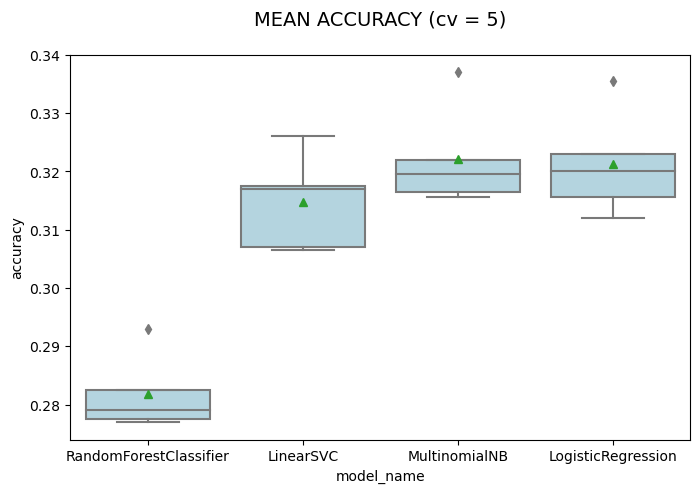

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

Evaluation

In [18]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Genre'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

       drama       0.14      0.06      0.08       306
    thriller       0.31      0.12      0.17       163
       adult       0.26      0.10      0.15       172
 documentary       0.08      0.03      0.04       120
      comedy       0.00      0.00      0.00        59
       crime       0.28      0.18      0.22      1867
  reality-tv       0.08      0.02      0.03       129
      horror       0.41      0.54      0.47      3229
       sport       0.37      0.62      0.46      3503
   animation       0.26      0.06      0.10       208
      action       0.00      0.00      0.00        76
     fantasy       0.29      0.14      0.19        43
       short       0.00      0.00      0.00        72
      sci-fi       0.38      0.30      0.33       558
       music       0.29      0.22      0.25       153
   adventure       0.09      0.01      0.03        69
   talk-show       0.20      0.03      0.05        6

Confusion Matrix

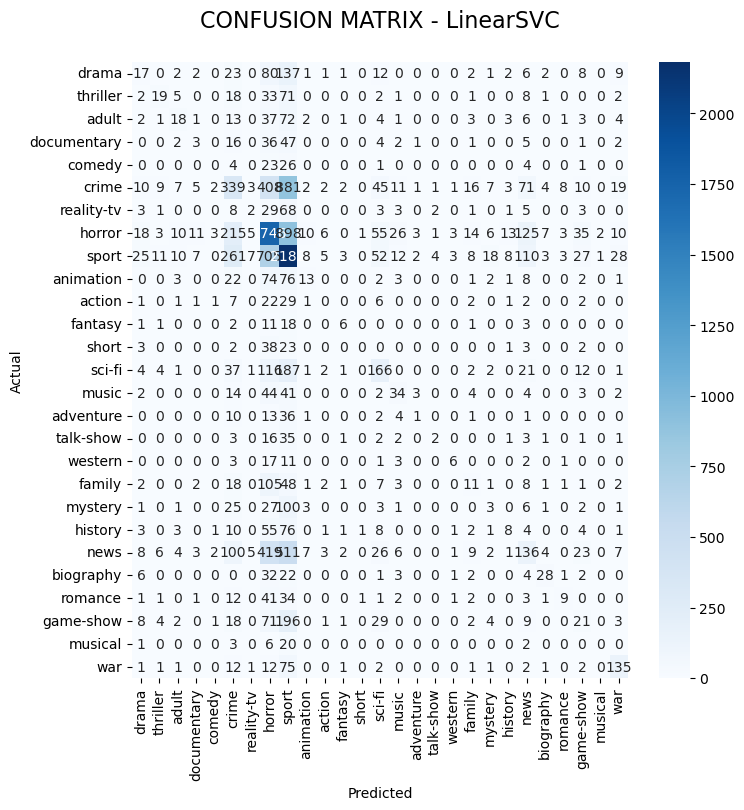

In [21]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Genre.values,
            yticklabels=category_id_df.Genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

### Analysing Results

Let’s have a look at the texts that were wrongly classified.

In [23]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Genre',
                                                                'Title']])
      print('')

'sport' predicted as 'drama' : 25 examples.


,Genre,Title



'drama' predicted as 'crime' : 23 examples.


,Genre,Title



'horror' predicted as 'crime' : 215 examples.


,Genre,Title



'sport' predicted as 'crime' : 261 examples.


,Genre,Title



'animation' predicted as 'crime' : 22 examples.


,Genre,Title



'sci-fi' predicted as 'crime' : 37 examples.


,Genre,Title



'mystery' predicted as 'crime' : 25 examples.


,Genre,Title



'news' predicted as 'crime' : 100 examples.


,Genre,Title



'drama' predicted as 'horror' : 80 examples.


,Genre,Title



'thriller' predicted as 'horror' : 33 examples.


,Genre,Title



'adult' predicted as 'horror' : 37 examples.


,Genre,Title



'documentary' predicted as 'horror' : 36 examples.


,Genre,Title



'comedy' predicted as 'horror' : 23 examples.


,Genre,Title



'crime' predicted as 'horror' : 408 examples.


,Genre,Title



'reality-tv' predicted as 'horror' : 29 examples.


,Genre,Title



'sport' predicted as 'horror' : 705 examples.


,Genre,Title



'animation' predicted as 'horror' : 74 examples.


,Genre,Title



'action' predicted as 'horror' : 22 examples.


,Genre,Title



'short' predicted as 'horror' : 38 examples.


,Genre,Title



'sci-fi' predicted as 'horror' : 116 examples.


,Genre,Title



'music' predicted as 'horror' : 44 examples.


,Genre,Title



'family' predicted as 'horror' : 105 examples.


,Genre,Title



'mystery' predicted as 'horror' : 27 examples.


,Genre,Title



'history' predicted as 'horror' : 55 examples.


,Genre,Title



'news' predicted as 'horror' : 419 examples.


,Genre,Title



'biography' predicted as 'horror' : 32 examples.


,Genre,Title



'romance' predicted as 'horror' : 41 examples.


,Genre,Title



'game-show' predicted as 'horror' : 71 examples.


,Genre,Title



'drama' predicted as 'sport' : 137 examples.


,Genre,Title



'thriller' predicted as 'sport' : 71 examples.


,Genre,Title



'adult' predicted as 'sport' : 72 examples.


,Genre,Title



'documentary' predicted as 'sport' : 47 examples.


,Genre,Title



'comedy' predicted as 'sport' : 26 examples.


,Genre,Title



'crime' predicted as 'sport' : 881 examples.


,Genre,Title



'reality-tv' predicted as 'sport' : 68 examples.


,Genre,Title



'horror' predicted as 'sport' : 898 examples.


,Genre,Title



'animation' predicted as 'sport' : 76 examples.


,Genre,Title



'action' predicted as 'sport' : 29 examples.


,Genre,Title



'short' predicted as 'sport' : 23 examples.


,Genre,Title



'sci-fi' predicted as 'sport' : 187 examples.


,Genre,Title



'music' predicted as 'sport' : 41 examples.


,Genre,Title



'adventure' predicted as 'sport' : 36 examples.


,Genre,Title



'talk-show' predicted as 'sport' : 35 examples.


,Genre,Title



'family' predicted as 'sport' : 48 examples.


,Genre,Title



'mystery' predicted as 'sport' : 100 examples.


,Genre,Title



'history' predicted as 'sport' : 76 examples.


,Genre,Title



'news' predicted as 'sport' : 511 examples.


,Genre,Title



'biography' predicted as 'sport' : 22 examples.


,Genre,Title



'romance' predicted as 'sport' : 34 examples.


,Genre,Title



'game-show' predicted as 'sport' : 196 examples.


,Genre,Title



'musical' predicted as 'sport' : 20 examples.


,Genre,Title



'war' predicted as 'sport' : 75 examples.


,Genre,Title



'crime' predicted as 'sci-fi' : 45 examples.


,Genre,Title



'horror' predicted as 'sci-fi' : 55 examples.


,Genre,Title



'sport' predicted as 'sci-fi' : 52 examples.


,Genre,Title



'news' predicted as 'sci-fi' : 26 examples.


,Genre,Title



'game-show' predicted as 'sci-fi' : 29 examples.


,Genre,Title



'horror' predicted as 'music' : 26 examples.


,Genre,Title



'crime' predicted as 'news' : 71 examples.


,Genre,Title



'horror' predicted as 'news' : 125 examples.


,Genre,Title



'sport' predicted as 'news' : 110 examples.


,Genre,Title



'sci-fi' predicted as 'news' : 21 examples.


,Genre,Title



'horror' predicted as 'game-show' : 35 examples.


,Genre,Title



'sport' predicted as 'game-show' : 27 examples.


,Genre,Title



'news' predicted as 'game-show' : 23 examples.


,Genre,Title



'sport' predicted as 'war' : 28 examples.


,Genre,Title


Most correlated terms with each category¶


In [24]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'action':
  * Top unigrams: webseries, potter, continent, tera
  * Top bigrams: ii 2005, beauty queen, land 2009, fan film

==> 'adult':
  * Top unigrams: kidnapping, cultures, bondage, trucks
  * Top bigrams: sam max, tales 1999, dangerous diva, tales 2000

==> 'adventure':
  * Top unigrams: musical, grammy, acrobats, romantic
  * Top bigrams: party 2012, live 2004, way home, 2012 2012

==> 'animation':
  * Top unigrams: barney, essence, puppy, romper
  * Top bigrams: romper room, lots lots, day life, 25th anniversary

==> 'biography':
  * Top unigrams: spetsnaz, championship, ufc, wcw
  * Top bigrams: world series, monday night, red bull, king ring

==> 'comedy':
  * Top unigrams: moore, strong, ernest, harbor
  * Top bigrams: tv 2011, red light, home 2009, secret life

==> 'crime':
  * Top unigrams: bikini, nerds, cinematic, comedy
  * Top bigrams: night live, web series, girls don, la película

==> 'documentary':
  * Top unigrams: bheem, gekijouban, kindness, cosmo
  * Top big

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)